In [3]:
import os
import pandas as pd
import numpy as np
import pickle
import numba
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, r2_score  # plot_roc_curve
from sklearn.metrics import RocCurveDisplay # for later sklearn versions  'plot_roc_curve'  
# see https://stackoverflow.com/questions/60321389/sklearn-importerror-cannot-import-name-plot-roc-curve

import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing  import StandardScaler

from sklearn.base import BaseEstimator, TransformerMixin
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from scipy.stats import spearmanr, pearsonr
from scipy.stats import ttest_ind
from collections import defaultdict
import seaborn as sns
import skopt
import time


import radipop_utils
import radipop_utils.features
from radipop_utils.features import SpearmanReducerCont

# extract path of repo. 
# path = Path(os.path.abspath(radipop_utils.__file__))
# RADIPOP_PACKAGE_ROOT = path.parent.parent

In [3]:
os.chdir("C://Users/marti/OneDrive - CeMM Research Center GmbH/stuff/sma/radipop_data_check")

In [4]:
#read feature data
data_all = pd.read_csv("csv_rawFeatures_s20220720.csv")
data_all = data_all.rename(columns = {'Unnamed: 0' : "ID"})

In [5]:
# restrict to only original
#data_all = data_all.loc[:, [x for x in data_all.columns if x.startswith("original_") or x.startswith("ID")]]

In [6]:
#read metadata
data_meta = pd.read_excel("Celine_FINAL_RADIOPOP_DATA_with LRE Death_220708.xlsx")

In [7]:
#split feature data into data from cirrhotic patients and data from healthy patients
data_sick = data_all.loc[data_all.ID.isin(data_meta.ID), :]
data_healthy = data_all.loc[~data_all.ID.isin(data_meta.ID), :]

In [8]:
#restrict metadata to relevant columns
data_meta = data_meta.loc[:,["ID", 'Training = 0, Testing = 1', "BL_HVPG_corrected (ohne Kollat., inkor. Messungen)"]]
print(data_meta.shape)
data_meta = pd.merge(pd.DataFrame({"ID" : data_sick.ID.values}), data_meta, how = "left", on = "ID")
print(data_meta.shape)

(442, 3)
(442, 3)


In [9]:
#add healthy patients to training cohort for metadata
data_meta_healthy = pd.DataFrame({"ID" : data_healthy.ID.values, 
                                  'Training = 0, Testing = 1' : 0, 
                                  "BL_HVPG_corrected (ohne Kollat., inkor. Messungen)" : 2.5})
data_meta = pd.concat((data_meta, data_meta_healthy)).reset_index(drop=True)

#add healthy patients to training cohort for feature data
data_all = pd.concat((data_sick, data_healthy)).reset_index(drop=True)

In [10]:
# add HVPG column variable to not have to deal with the weird column name
data_meta["HVPG"] = data_meta["BL_HVPG_corrected (ohne Kollat., inkor. Messungen)"]

In [11]:
# perform train test split
data_train = data_all.loc[data_meta['Training = 0, Testing = 1'] == 0, :]
meta_train = data_meta.loc[data_meta['Training = 0, Testing = 1'] == 0, :]

data_test = data_all.loc[data_meta['Training = 0, Testing = 1'] == 1, :]
meta_test = data_meta.loc[data_meta['Training = 0, Testing = 1'] == 1, :]


In [12]:
#extract np arrays
X_train, Y_train = data_train.loc[:,[x for x in data_train.columns if not x == "ID"]].values, meta_train.HVPG.values
X_test, Y_test = data_test.loc[:,[x for x in data_test.columns if not x == "ID"]].values, meta_test.HVPG.values

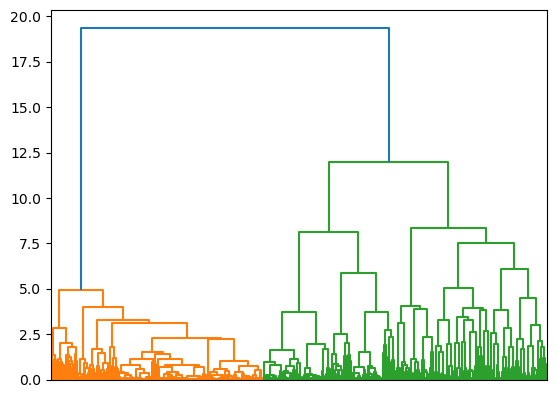

In [13]:
#plot dendrogram
corr = spearmanr(X_train).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
plt.figure()
dendro = hierarchy.dendrogram(
    dist_linkage, no_labels=True
)

In [14]:
#decide on cut parameters for dendrogram
selector = SpearmanReducerCont(0.5)
print("Selected features at height 0.5:", len(selector.fit(X_train, Y_train).selected_features))
selector = SpearmanReducerCont(0.75)
print("Selected features at height 0.75:", len(selector.fit(X_train, Y_train).selected_features))
selector = SpearmanReducerCont(1)
print("Selected features at height 1:", len(selector.fit(X_train, Y_train).selected_features))
selector = SpearmanReducerCont(5)
print("Selected features at height 5:", len(selector.fit(X_train, Y_train).selected_features))
selector = SpearmanReducerCont(7.5)
print("Selected features at height 7.5:", len(selector.fit(X_train, Y_train).selected_features))
selector = SpearmanReducerCont(10)
print("Selected features at height 10:", len(selector.fit(X_train, Y_train).selected_features))

Selected features at height 0.5: 213
Selected features at height 0.75: 132
Selected features at height 1: 97
Selected features at height 5: 9
Selected features at height 7.5: 6
Selected features at height 10: 3


In [15]:
# Bounds for hyperparameters
param_bounds_rf = {
    'feature_selection__split_param' : skopt.space.Real(1,5, prior = "uniform"),
    'regression' : [RandomForestRegressor(random_state=2023)],
    'regression__n_estimators': skopt.space.Integer(100, 2000),
    'regression__max_depth': skopt.space.Integer(1, 50),
    'regression__min_samples_split': skopt.space.Integer(2, 25)#,
}



param_bounds_en = {
                 'feature_selection__split_param' : skopt.space.Real(1,5, prior = "uniform"),
                 'regression' : [ElasticNet(random_state=2023)],
                 'regression__alpha': skopt.space.Real(0.0001, 1.0, 'uniform'),
                 'regression__l1_ratio': skopt.space.Real(0, 1.0, 'uniform')
}


In [16]:
#create a pipeline
reg = Pipeline([
  #('scaler', StandardScaler()),  
  ('feature_selection', SpearmanReducerCont()),
  ('regression', RandomForestRegressor())
]) 

In [17]:
cv5 = KFold(5, shuffle=True, random_state=2023)

In [18]:
#try out models
opt0 = skopt.BayesSearchCV(
    reg,
    [(param_bounds_en, 10), (param_bounds_rf, 10)],
    cv=cv5,
    scoring="r2",
    verbose=True,
    random_state=2023,
    n_jobs = 6
)
opt0.fit(X_train, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

BayesSearchCV(cv=KFold(n_splits=5, random_state=2023, shuffle=True),
              estimator=Pipeline(steps=[('feature_selection',
                                         SpearmanReducerCont()),
                                        ('regression',
                                         RandomForestRegressor())]),
              n_jobs=6, random_state=2023, scoring='r2',
              search_spaces=[({'feature_selection__split_param': Real(low=1, high=5, prior='uniform', transform='normalize'),
                               'regression': [ElasticNet(r...
                               'regression': [RandomForestRegressor(max_depth=47,
                                                                    min_samples_split=24,
                                                                    n_estimators=1766,
                                                                    random_state=2023)],
                               'regression__max_depth': Integer(low=1, high=50, prior='

In [19]:
print(opt0.best_params_)

OrderedDict([('feature_selection__split_param', 1.2475405520173637), ('regression', RandomForestRegressor(max_depth=47, min_samples_split=24, n_estimators=1766,
                      random_state=2023)), ('regression__max_depth', 47), ('regression__min_samples_split', 24), ('regression__n_estimators', 1766)])


<AxesSubplot:>

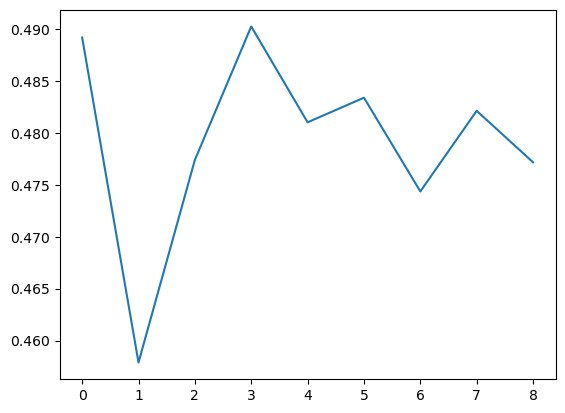

In [20]:
cv_res = pd.DataFrame(opt0.cv_results_)
cv_res
cv_res.iloc[11:, :].reset_index().loc[:, "mean_test_score"].plot()

In [33]:
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_selection__split_param,param_regression,param_regression__alpha,param_regression__l1_ratio,param_regression__max_depth,param_regression__min_samples_split,param_regression__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,6.764711,0.390835,0.000810,0.000405,2.743571,ElasticNet(random_state=2023),0.387402,0.128819,NaN,NaN,NaN,{'feature_selection__split_param': 2.743571433...,0.366304,0.306541,0.423949,0.379728,0.216051,0.338515,0.071818,12
1,6.260588,0.131448,0.000699,0.000398,3.284402,ElasticNet(random_state=2023),0.985515,0.703889,NaN,NaN,NaN,{'feature_selection__split_param': 3.284402090...,0.069139,-0.028147,0.223998,0.339839,0.141605,0.149287,0.126378,20
2,6.023943,0.047322,0.000598,0.000488,4.149169,ElasticNet(random_state=2023),0.721623,0.930024,NaN,NaN,NaN,{'feature_selection__split_param': 4.149169393...,0.218808,0.254544,0.223924,0.363948,0.134302,0.239105,0.074095,17
3,6.227677,0.031293,0.001196,0.000255,2.883225,ElasticNet(random_state=2023),0.324929,0.066263,NaN,NaN,NaN,{'feature_selection__split_param': 2.883225269...,0.204800,0.315771,0.299928,0.371089,0.172852,0.272888,0.073289,13
4,6.136079,0.049824,0.001018,0.000569,3.80773,ElasticNet(random_state=2023),0.975746,0.854681,NaN,NaN,NaN,{'feature_selection__split_param': 3.807729785...,0.218535,0.266258,0.219201,0.363806,0.129025,0.239365,0.076452,16
5,6.283509,0.118378,0.000224,0.000447,2.24902,ElasticNet(random_state=2023),0.504889,0.786739,NaN,NaN,NaN,{'feature_selection__split_param': 2.249020143...,0.333398,0.376190,0.428899,0.352303,0.278831,0.353924,0.049356,11
6,6.526677,0.074351,0.001200,0.000397,4.406906,ElasticNet(random_state=2023),0.261723,0.06709,NaN,NaN,NaN,{'feature_selection__split_param': 4.406905681...,0.224696,0.310734,0.241604,0.380064,0.128087,0.257037,0.084772,15
7,6.331858,0.042941,0.000893,0.000480,4.592474,ElasticNet(random_state=2023),0.556117,0.92798,NaN,NaN,NaN,{'feature_selection__split_param': 4.592474169...,0.208997,0.253802,0.219442,0.366172,0.115923,0.232867,0.080789,18
8,6.325656,0.081140,0.000199,0.000398,3.186457,ElasticNet(random_state=2023),0.237075,0.058609,NaN,NaN,NaN,{'feature_selection__split_param': 3.186456979...,0.196455,0.058811,0.244503,0.357273,0.169841,0.205376,0.097393,19
9,6.265744,0.090980,0.000321,0.000642,3.707944,ElasticNet(random_state=2023),0.58116,0.544714,NaN,NaN,NaN,{'feature_selection__split_param': 3.707943921...,0.344782,0.271619,0.233303,0.345092,0.141291,0.267217,0.076299,14


In [21]:
cv_res.to_excel("Bayesian_results_10_iterations_RFvsEN.xlsx")

In [22]:
#create a pipeline
reg = Pipeline([
  #('scaler', StandardScaler()),  
  ('feature_selection', SpearmanReducerCont()),
  ('regression', RandomForestRegressor())
]) 


In [23]:
#Set params
np.random.seed(2023)
print(opt0.best_params_)
reg.set_params(**opt0.best_params_)

OrderedDict([('feature_selection__split_param', 1.2475405520173637), ('regression', RandomForestRegressor(max_depth=47, min_samples_split=24, n_estimators=1766,
                      random_state=2023)), ('regression__max_depth', 47), ('regression__min_samples_split', 24), ('regression__n_estimators', 1766)])


Pipeline(steps=[('feature_selection',
                 SpearmanReducerCont(split_param=1.2475405520173637)),
                ('regression',
                 RandomForestRegressor(max_depth=47, min_samples_split=24,
                                       n_estimators=1766, random_state=2023))])

In [37]:
#supp data - training data performance

# set best performing en model (rf model has already been set)
#create a pipeline
reg_EN = Pipeline([
  #('scaler', StandardScaler()),  
  ('feature_selection', SpearmanReducerCont()),
  ('regression', ElasticNet())
]) 

reg_EN.set_params(**cv_res.iloc[5, :].params)

#run 5 fold cv
rf_train_res = np.array([])
en_train_res = np.array([])
obs = np.array([])

for train, test in cv5.split(X_train):
    
    #rf
    reg.fit(X_train[train], Y_train[train])
    rf_train_res = np.append(rf_train_res, reg.predict(X_train[test]))
    
    #en
    reg_EN.fit(X_train[train], Y_train[train])
    en_train_res = np.append(en_train_res, reg_EN.predict(X_train[test]))
    
    #obs
    obs = np.append(obs, Y_train[test])

In [42]:
res_training = pd.DataFrame({"True_HVPG" : obs, 
                             "RF_HVPG" : rf_train_res,
                             "EN_HVPG" : en_train_res})


In [44]:
#os.makedirs("model_training")
res_training.to_excel("model_training/CV_results_training_cohort.xlsx")

In [41]:
pearsonr(obs, en_train_res)

(0.6026794223370244, 1.693478747403296e-48)

In [24]:
#train the final model
reg.fit(X_train, Y_train)
res = reg.predict(X_test)


In [25]:
pearsonr(res, Y_test)

(0.6321034889427126, 8.701146853118389e-11)

In [26]:
r2_score(Y_test, res)

0.3885989918305509

In [27]:
hvpg_cat = [0 if x < 10 else 1 for x in meta_test.HVPG]
roc_auc_score(hvpg_cat, res)

0.8553333333333334

In [28]:
reg.named_steps["regression"].feature_importances_.shape

(74,)

In [29]:
np.sum(reg.named_steps["regression"].feature_importances_>0)

74

In [30]:
#export feature importances
selector = SpearmanReducerCont(opt0.best_params_['feature_selection__split_param'])
selector.fit(X_train, Y_train)
features = np.array([x for x in data_train.columns if not x == "ID"])
feat_imp = pd.DataFrame({
    "feature": features[selector.selected_features],
    "importance": reg.named_steps["regression"].feature_importances_})
feat_imp.sort_values("importance", ascending=False).to_excel("Feature_importances_RF_regressor.xlsx")

In [31]:
#export prediction data
meta_test.loc[:,"rHVPG"] = res

C:\Users\marti\anaconda3\envs\radio\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [32]:
meta_test.to_excel("Metadata_with_predictions.xlsx")

In [32]:
#external validation
data_val = pd.read_excel("External_validation_features.xlsx")

#read hvpg for external validation cohort
data_ext_val_hvpg = pd.read_excel("D:/FINAL.External_validation_cohort_RADIPOP_with_additions.xlsx")

data_ext_val_hvpg = pd.DataFrame({"ID" : ["V "+str(x) for x in data_ext_val_hvpg["ID paris"]],
                                  "HVPG" : data_ext_val_hvpg["HVPG"]})

data_ext_val_hvpg = pd.merge(pd.DataFrame({"ID" : data_val["ID"]}), data_ext_val_hvpg, on="ID")

#synchronize columns
data_val = data_val.loc[:, data_all.columns]



FileNotFoundError: [Errno 2] No such file or directory: 'D:/FINAL.External_validation_cohort_RADIPOP_with_additions.xlsx'

In [ ]:
X_val, Y_val = data_val.loc[:, [x for x in data_test.columns if not x == "ID"]].values, data_ext_val_hvpg.HVPG.values

In [ ]:
res_val = reg.predict(X_val)

In [ ]:
pearsonr(res_val, Y_val)

In [ ]:
r2_score(Y_val, res_val)

In [ ]:
hvpg_cat = [0 if x < 10 else 1 for x in Y_val]
roc_auc_score(hvpg_cat, res_val)

In [ ]:
sns.regplot(x = np.array(Y_val, dtype = float), y = res_val)

In [ ]:
data_ext_val_hvpg["rHVPG"] = res_val
data_ext_val_hvpg.to_excel("Metadata_ext_with_predictions.xlsx")

In [ ]:
#os.makedirs("Final_model")
with open(os.path.join("Final_model", "SpearmanRed1_RF_10.p"), "wb") as fp:
    pickle.dump(reg, fp)
    
with open(os.path.join("Final_model", "SpearmanRed1_RF_10_opt.p"), "wb") as fp:
    pickle.dump(opt0, fp)